<a href="https://colab.research.google.com/github/ElisabethShah/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/Model%20Interpretation%20Assignment%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Permutation Importances, Partial Dependence Plots

## Overview

### Objectives
- Get and interpret permutation importances
- Visualize and interpret partial dependence plots

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
  - [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)
  - [Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
  - [(Permutation) Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
  - [Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- Random Forest Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

### Libraries
- [eli5](https://github.com/TeamHG-Memex/eli5): `conda install -c conda-forge eli5` / `pip install eli5`
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding): `conda install -c conda-forge category_encoders` / `pip install category_encoders`

### Library quirks to work around

1. Some of these libraries don't work with pipelines.

2. eli5 PermutationImportance + xgboost + pandas didn't work. The bug seems to be fixed now, but if you have problems, [there's a work-around:](https://www.kaggle.com/dansbecker/permutation-importance#392299)

> Important note here for anyone trying to use eli5's PermutationImportance on XGBoost estimators, currently you need to train your models using ".values or .as_matrix()" with you input data (X and Y), otherwise PermutationImportance won't work, [source](https://github.com/TeamHG-Memex/eli5/issues/256).

3. PDPbox _only_ works with pandas.

4. With PDPBox version <= 0.20, using the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works. [This issue](https://github.com/SauceCat/PDPbox/issues/40) will be fixed in the next release of PDPbox.

**[(Data science is often about putting square pegs in round holes!)](https://www.youtube.com/watch?v=ry55--J4_VQ)**

### Three types of model explanations:

**1. Global model explanation: all features in relation to each other**
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

**2. Global model explanation: individual feature(s) in relation to target**
- Partial Dependence plots

**3. Individual prediction explanation**
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

## Setup

### Install dependencies

In [1]:
# For Google Colab.
!pip install eli5 pdpbox category_encoders shap

     |████████████████████████████████| 102kB 6.1MB/s 
     |████████████████████████████████| 57.7MB 1.4MB/s 
     |████████████████████████████████| 92kB 24.6MB/s 
     |████████████████████████████████| 235kB 29.4MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=8643a318883164642dad7c829c9eee002251ec7d9ecc5d6c7dc4f2fed3454d38
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=344728 sha256=99ac93d5a4a89ef526830368a2f6d0b8feb5385f445015d9d16fc592d0a8c316
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built pdpbox shap


### Import libraries

In [0]:
import category_encoders as ce
import eli5
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdpbox
import shap
import urllib.request
import zipfile

%matplotlib inline

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Define utility functions

In [0]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [0]:
def custom_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return -rmse(y_true, y_pred)

### Load data

Data source: [National Center for Education Statistics](https://nces.ed.gov/ipeds/datacenter/DataFiles.aspx)

In [0]:
data_urls = ['https://nces.ed.gov/ipeds/datacenter/data/HD2017.zip',
             'https://nces.ed.gov/ipeds/datacenter/data/IC2017.zip',
             'https://nces.ed.gov/ipeds/datacenter/data/IC2017_AY.zip',
            ]

data_files = ['HD2017.zip',
              'IC2017.zip', 
              'IC2017_AY.zip', 
             ]

In [0]:
for url, file in zip(data_urls, data_files):
    urllib.request.urlretrieve(url, file)

In [0]:
for file in data_files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('.')

In [0]:
institutions = pd.read_csv('hd2017.csv', encoding='ISO-8859-1')

In [10]:
institutions.columns

Index(['UNITID', 'INSTNM', 'IALIAS', 'ADDR', 'CITY', 'STABBR', 'ZIP', 'FIPS',
       'OBEREG', 'CHFNM', 'CHFTITLE', 'GENTELE', 'EIN', 'DUNS', 'OPEID',
       'OPEFLAG', 'WEBADDR', 'ADMINURL', 'FAIDURL', 'APPLURL', 'NPRICURL',
       'VETURL', 'ATHURL', 'DISAURL', 'SECTOR', 'ICLEVEL', 'CONTROL',
       'HLOFFER', 'UGOFFER', 'GROFFER', 'HDEGOFR1', 'DEGGRANT', 'HBCU',
       'HOSPITAL', 'MEDICAL', 'TRIBAL', 'LOCALE', 'OPENPUBL', 'ACT', 'NEWID',
       'DEATHYR', 'CLOSEDAT', 'CYACTIVE', 'POSTSEC', 'PSEFLAG', 'PSET4FLG',
       'RPTMTH', 'INSTCAT', 'C15BASIC', 'C15IPUG', 'C15IPGRD', 'C15UGPRF',
       'C15ENPRF', 'C15SZSET', 'CCBASIC', 'CARNEGIE', 'LANDGRNT', 'INSTSIZE',
       'F1SYSTYP', 'F1SYSNAM', 'F1SYSCOD', 'CBSA', 'CBSATYPE', 'CSA', 'NECTA',
       'COUNTYCD', 'COUNTYNM', 'CNGDSTCD', 'LONGITUD', 'LATITUDE', 'DFRCGID',
       'DFRCUSCG'],
      dtype='object')

In [0]:
institution_details = pd.read_csv('ic2017.csv', encoding='ISO-8859-1')

In [12]:
institution_details.columns.to_list()

['UNITID',
 'PEO1ISTR',
 'PEO2ISTR',
 'PEO3ISTR',
 'PEO4ISTR',
 'PEO5ISTR',
 'PEO6ISTR',
 'CNTLAFFI',
 'PUBPRIME',
 'PUBSECON',
 'RELAFFIL',
 'LEVEL1',
 'LEVEL2',
 'LEVEL3',
 'LEVEL4',
 'LEVEL5',
 'LEVEL6',
 'LEVEL7',
 'LEVEL8',
 'LEVEL12',
 'LEVEL17',
 'LEVEL18',
 'LEVEL19',
 'CALSYS',
 'FT_UG',
 'FT_FTUG',
 'FTGDNIDP',
 'PT_UG',
 'PT_FTUG',
 'PTGDNIDP',
 'DOCPP',
 'DOCPPSP',
 'OPENADMP',
 'VET1',
 'VET2',
 'VET3',
 'VET4',
 'VET5',
 'VET9',
 'CREDITS1',
 'CREDITS2',
 'CREDITS3',
 'CREDITS4',
 'SLO5',
 'SLO51',
 'SLO52',
 'SLO53',
 'SLO6',
 'SLO7',
 'SLO8',
 'SLO81',
 'SLO82',
 'SLO83',
 'SLO9',
 'YRSCOLL',
 'STUSRV1',
 'STUSRV2',
 'STUSRV3',
 'STUSRV4',
 'STUSRV8',
 'STUSRV9',
 'LIBRES1',
 'LIBRES2',
 'LIBRES3',
 'LIBRES4',
 'LIBRES5',
 'LIBRES6',
 'LIBRES9',
 'TUITPL',
 'TUITPL1',
 'TUITPL2',
 'TUITPL3',
 'TUITPL4',
 'DSTNUGC',
 'DSTNUGP',
 'DSTNUGN',
 'DSTNGC',
 'DSTNGP',
 'DSTNGN',
 'DISTCRS',
 'DISTPGS',
 'DSTNCED1',
 'DSTNCED2',
 'DSTNCED3',
 'DISTNCED',
 'DISAB',
 'XDISABPC',
 'DISABPCT',
 'ALLONCAM',
 'TUITVARY',
 'ROOM',
 'XROOMCAP',
 'ROOMCAP',
 'BOARD',
 'XMEALSWK',
 'MEALSWK',
 'XROOMAMT',
 'ROOMAMT',
 'XBORDAMT',
 'BOARDAMT',
 'XRMBDAMT',
 'RMBRDAMT',
 'XAPPFEEU',
 'APPLFEEU',
 'XAPPFEEG',
 'APPLFEEG',
 'ATHASSOC',
 'ASSOC1',
 'ASSOC2',
 'ASSOC3',
 'ASSOC4',
 'ASSOC5',
 'ASSOC6',
 'SPORT1',
 'CONFNO1',
 'SPORT2',
 'CONFNO2',
 'SPORT3',
 'CONFNO3',
 'SPORT4',
 'CONFNO4 ']

In [0]:
detail_features = ['UNITID', 
                   'LEVEL5', 
                   'LIBRES1',
                   'LIBRES2',
                   'LIBRES3',
                   'LIBRES4',
                   'LIBRES5',
                   'LIBRES6',
                   'LIBRES9',
                  ]

In [0]:
tuition = pd.read_csv('ic2017_ay.csv', encoding='ISO-8859-1')

In [0]:
target = 'TUITION3'

In [0]:
data = institutions.merge(institution_details[detail_features])

In [17]:
data.columns

Index(['UNITID', 'INSTNM', 'IALIAS', 'ADDR', 'CITY', 'STABBR', 'ZIP', 'FIPS',
       'OBEREG', 'CHFNM', 'CHFTITLE', 'GENTELE', 'EIN', 'DUNS', 'OPEID',
       'OPEFLAG', 'WEBADDR', 'ADMINURL', 'FAIDURL', 'APPLURL', 'NPRICURL',
       'VETURL', 'ATHURL', 'DISAURL', 'SECTOR', 'ICLEVEL', 'CONTROL',
       'HLOFFER', 'UGOFFER', 'GROFFER', 'HDEGOFR1', 'DEGGRANT', 'HBCU',
       'HOSPITAL', 'MEDICAL', 'TRIBAL', 'LOCALE', 'OPENPUBL', 'ACT', 'NEWID',
       'DEATHYR', 'CLOSEDAT', 'CYACTIVE', 'POSTSEC', 'PSEFLAG', 'PSET4FLG',
       'RPTMTH', 'INSTCAT', 'C15BASIC', 'C15IPUG', 'C15IPGRD', 'C15UGPRF',
       'C15ENPRF', 'C15SZSET', 'CCBASIC', 'CARNEGIE', 'LANDGRNT', 'INSTSIZE',
       'F1SYSTYP', 'F1SYSNAM', 'F1SYSCOD', 'CBSA', 'CBSATYPE', 'CSA', 'NECTA',
       'COUNTYCD', 'COUNTYNM', 'CNGDSTCD', 'LONGITUD', 'LATITUDE', 'DFRCGID',
       'DFRCUSCG', 'LEVEL5', 'LIBRES1', 'LIBRES2', 'LIBRES3', 'LIBRES4',
       'LIBRES5', 'LIBRES6', 'LIBRES9'],
      dtype='object')

In [0]:
data = data[data['LEVEL5'] == 1]

In [0]:
data = data.merge(tuition[['UNITID', target]])

In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
UNITID,2602.0,2.361966e+05,1.153576e+05,100654.000000,1.577592e+05,1.996250e+05,2.382912e+05,4.912880e+05
FIPS,2602.0,3.012836e+01,1.663271e+01,1.000000,1.700000e+01,3.100000e+01,4.200000e+01,7.800000e+01
OBEREG,2602.0,4.451191e+00,2.216320e+00,0.000000,3.000000e+00,5.000000e+00,6.000000e+00,9.000000e+00
EIN,2602.0,4.817259e+08,2.665898e+08,-1.000000,2.514769e+08,4.646999e+08,6.603773e+08,9.960004e+08
OPEFLAG,2602.0,1.159877e+00,8.833309e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
SECTOR,2602.0,1.882398e+00,6.660937e-01,1.000000,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
ICLEVEL,2602.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CONTROL,2602.0,1.882398e+00,6.660937e-01,1.000000,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
HLOFFER,2602.0,7.192929e+00,1.640645e+00,5.000000,5.000000e+00,7.000000e+00,9.000000e+00,9.000000e+00
UGOFFER,2602.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [21]:
data.nunique().sort_values(ascending=False).head(25)

UNITID      2602
LATITUDE    2590
LONGITUD    2590
OPEID       2577
INSTNM      2575
ADDR        2562
GENTELE     2549
ZIP         2482
WEBADDR     2442
CHFNM       2412
DISAURL     2243
DUNS        2193
NPRICURL    2165
ADMINURL    2141
FAIDURL     2128
EIN         2080
APPLURL     1944
TUITION3    1874
VETURL      1494
CITY        1269
IALIAS       995
COUNTYCD     953
ATHURL       870
COUNTYNM     728
CBSA         577
dtype: int64

In [0]:
data.loc[data['TUITION3']=='.'] = 0

In [0]:
data['TUITION3'] = data['TUITION3'].astype(int)

In [0]:
data = data[data['UNITID'] != 0]

In [0]:
identifying_features = ['UNITID', 
                        'INSTNM', 
                        'IALIAS', 
                        'ADDR', 
                        'ZIP', 
                        'CHFNM', 
                        'GENTELE', 
                        'EIN', 
                        'DUNS',
                        'OPEID',
                        'WEBADDR', 
                        'DISAURL', 
                        'NPRICURL', 
                        'ADMINURL', 
                        'FAIDURL', 
                        'APPLURL', 
                        'VETURL', 
                        'ATHURL',]

In [0]:
data = data.drop(columns=identifying_features)

In [0]:
string_features = ['CITY', 'STABBR', 'CHFTITLE', 'ACT', 'CLOSEDAT', 'F1SYSNAM', 'COUNTYNM']

In [0]:
data = data.drop(columns=string_features)

## Split into training, validation, and test datasets

In [0]:
trainval, test = train_test_split(data)

In [0]:
train, val = train_test_split(trainval)

In [0]:
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns=target)

y_train = train[target]
y_val = val[target]
y_test = test[target]

## Establish baseline for regression

In [0]:
y_train_pred_bl = np.full_like(y_train, y_train.mean())
y_val_pred_bl = np.full_like(y_val, y_train.mean())

In [33]:
score_bl = rmse(y_val, y_val_pred_bl)
print("Validation RMSE: {:.3f}" .format(score_bl))

Validation RMSE: 12869.613


In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [0]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [36]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's l1: 10043.5	valid_0's l2: 1.53959e+08
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 9696.65	valid_0's l2: 1.43449e+08
[3]	valid_0's l1: 9368.79	valid_0's l2: 1.33901e+08
[4]	valid_0's l1: 9085.99	valid_0's l2: 1.258e+08
[5]	valid_0's l1: 8816.87	valid_0's l2: 1.18426e+08
[6]	valid_0's l1: 8531.43	valid_0's l2: 1.11045e+08
[7]	valid_0's l1: 8263.88	valid_0's l2: 1.04383e+08
[8]	valid_0's l1: 8024.68	valid_0's l2: 9.84954e+07
[9]	valid_0's l1: 7798.38	valid_0's l2: 9.3227e+07
[10]	valid_0's l1: 7589.02	valid_0's l2: 8.85045e+07
[11]	valid_0's l1: 7394.72	valid_0's l2: 8.43014e+07
[12]	valid_0's l1: 7192.14	valid_0's l2: 7.98345e+07
[13]	valid_0's l1: 7041.15	valid_0's l2: 7.66525e+07
[14]	valid_0's l1: 6878.79	valid_0's l2: 7.32385e+07
[15]	valid_0's l1: 6718.28	valid_0's l2: 7.00292e+07
[16]	valid_0's l1: 6558.57	valid_0's l2: 6.7037e+07
[17]	valid_0's l1: 6415.76	valid_0's l2: 6.44043e+07
[18]	valid_0's l1: 6276.83	valid_0's l2: 6.19407e+0

In [37]:
y_val_pred = gbm.predict(X_val)
score = rmse(y_val, y_val_pred)
print("Validation RMSE: {:.3f}" .format(score))

Validation RMSE: 7611.919


## Plot feature importances

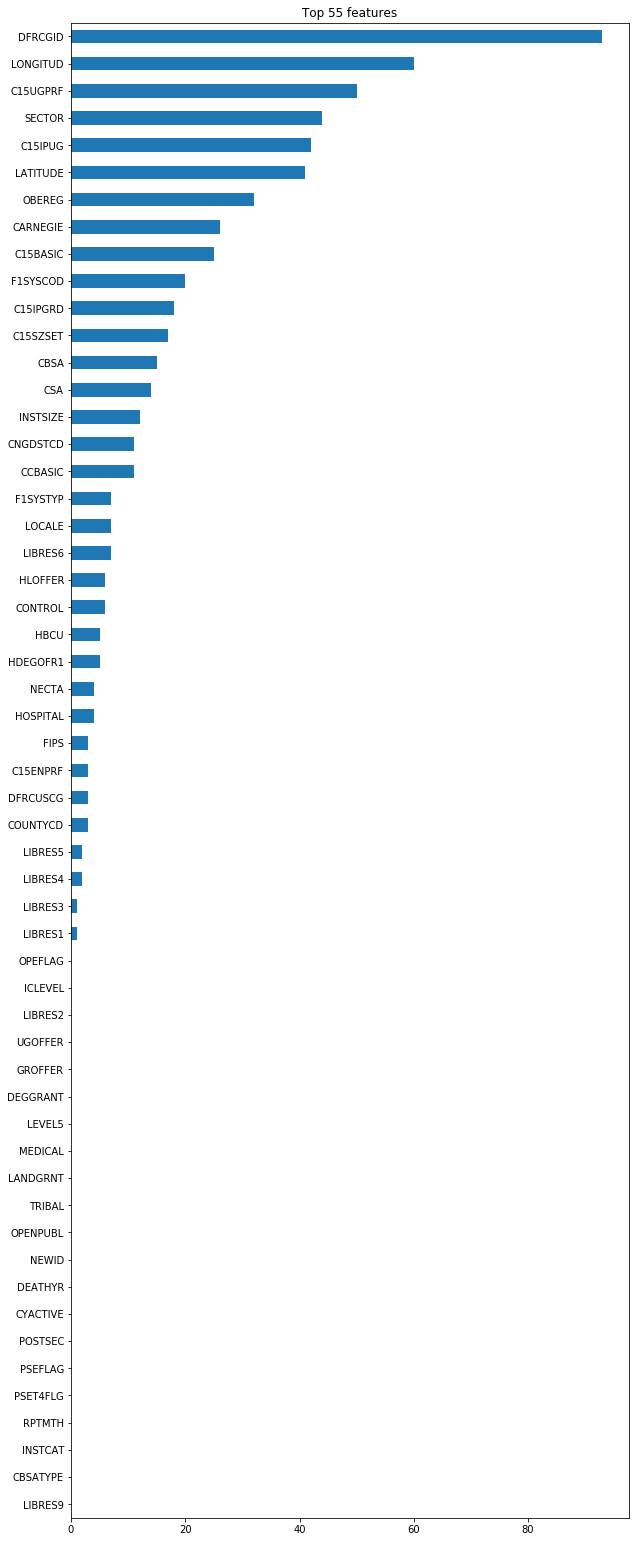

In [38]:
importances = pd.Series(gbm.feature_importance(), X_train.columns)

n = len(X_train.columns)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

## Evaluate permutation importances

In [0]:
model = RandomForestRegressor(n_estimators=10, random_state=0).fit(X_train, y_train)

In [40]:
y_val_pred = model.predict(X_val)
score = rmse(y_val, y_val_pred)
print("Validation RMSE: {:.3f}" .format(score))

Validation RMSE: 6231.863


In [41]:
permuter = eli5.sklearn.PermutationImportance(model, 
                                              scoring='neg_mean_squared_error', 
                                              cv='prefit', 
                                              n_iter=5, 
                                              random_state=0)

permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
90874064.4656 ± 8654926.6915,C15UGPRF
26860874.1151 ± 5569642.6101,DFRCGID
10418196.2991 ± 3224299.5679,CONTROL
8680499.9745 ± 3022201.8046,SECTOR
8577260.2291 ± 1002866.7637,C15IPUG
5705142.1595 ± 3154427.9403,OBEREG
5528418.5678 ± 2055099.6752,CARNEGIE
5462038.1479 ± 1538778.8627,LONGITUD
3286294.1499 ± 1136803.8549,C15BASIC
3055245.1621 ± 1288231.1771,LATITUDE


In [42]:
permuter = eli5.sklearn.PermutationImportance(model, 
                                              scoring=custom_scorer, 
                                              cv='prefit', 
                                              n_iter=5, 
                                              random_state=0)

permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
5155.5742 ± 381.8320,C15UGPRF
1871.6976 ± 342.3125,DFRCGID
785.3198 ± 232.0108,CONTROL
660.4964 ± 219.0680,SECTOR
653.7776 ± 72.9244,C15IPUG
441.0109 ± 236.7400,OBEREG
428.3625 ± 154.0194,CARNEGIE
423.5736 ± 115.2011,LONGITUD
258.1658 ± 88.0215,C15BASIC
240.2991 ± 99.5732,LATITUDE


## Generate partial dependence plots

### Single-feature PDPs

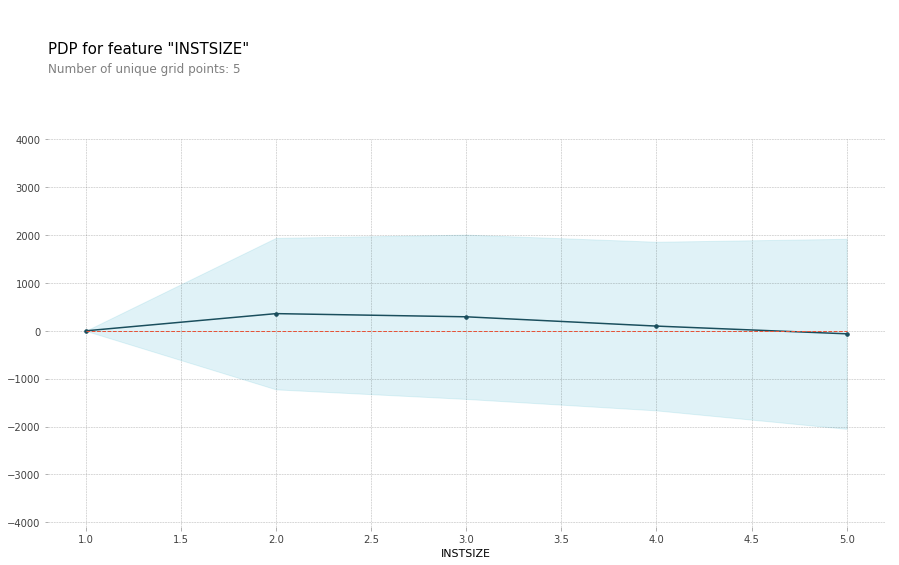

In [43]:
feature = 'INSTSIZE'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

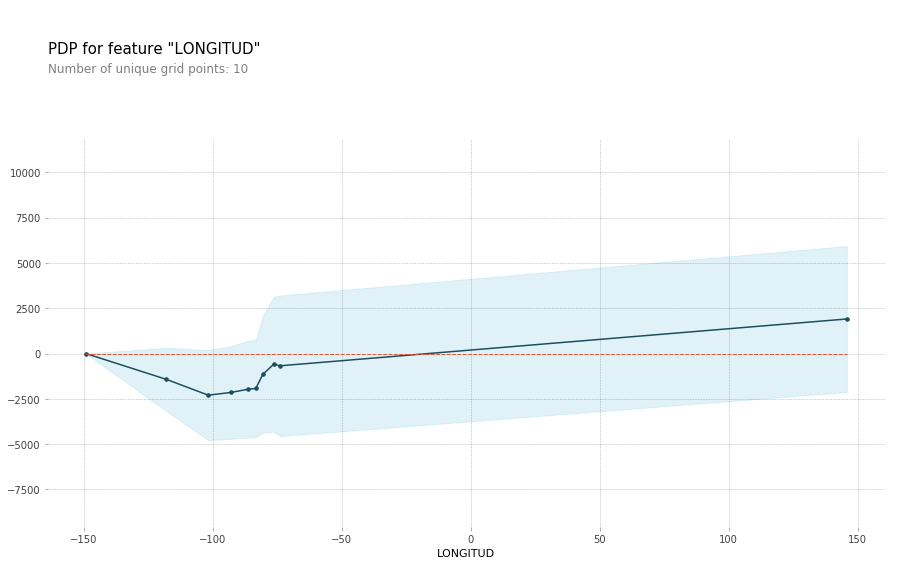

In [44]:
feature = 'LONGITUD'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

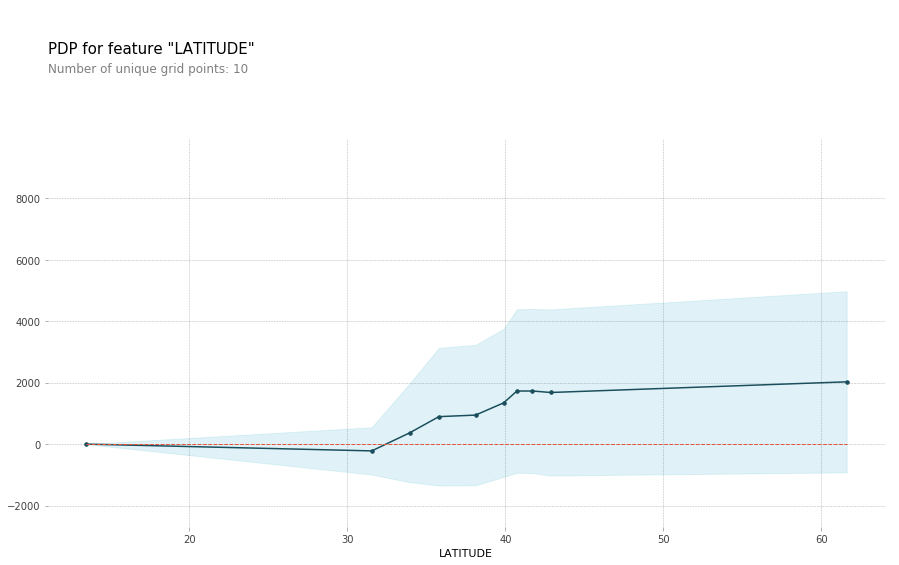

In [45]:
feature = 'LATITUDE'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

### Two-feature PDP

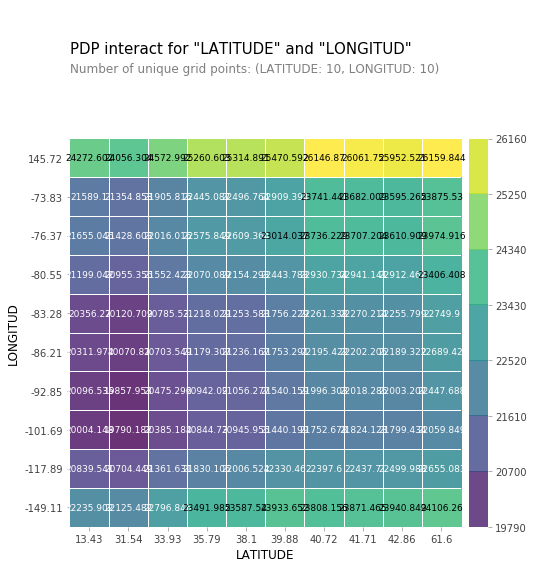

In [46]:
features = ['LATITUDE', 'LONGITUD']

interaction = pdp_interact(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

## Generate Shapely value plot

In [47]:
sample = y_val.sample()
sample

551    13100
Name: TUITION3, dtype: int64

In [48]:
y_val[sample.index[0]]

13100

In [49]:
data_for_prediction= X_val[X_val.index == sample.index[0]]
data_for_prediction

,FIPS,OBEREG,OPEFLAG,SECTOR,ICLEVEL,CONTROL,HLOFFER,UGOFFER,GROFFER,HDEGOFR1,DEGGRANT,HBCU,HOSPITAL,MEDICAL,TRIBAL,LOCALE,OPENPUBL,NEWID,DEATHYR,CYACTIVE,POSTSEC,PSEFLAG,PSET4FLG,RPTMTH,INSTCAT,C15BASIC,C15IPUG,C15IPGRD,C15UGPRF,C15ENPRF,C15SZSET,CCBASIC,CARNEGIE,LANDGRNT,INSTSIZE,F1SYSTYP,F1SYSCOD,CBSA,CBSATYPE,CSA,NECTA,COUNTYCD,CNGDSTCD,LONGITUD,LATITUDE,DFRCGID,DFRCUSCG,LEVEL5,LIBRES1,LIBRES2,LIBRES3,LIBRES4,LIBRES5,LIBRES6,LIBRES9
551,18,3,1,1,1,1,5,1,2,30,1,2,2,2,2,33,1,-2,-2,1,1,1,1,1,3,14,5,0,6,2,16,12,40,2,4,2,-2,47180,2,-2,-2,18083,1808,-87.519939,38.687766,208,1,1,1,1,1,1,1,1,0


In [50]:
model.predict(data_for_prediction)

array([5819.4])

In [51]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [52]:
explainer.expected_value + shap_values.sum()

5819.400020706698

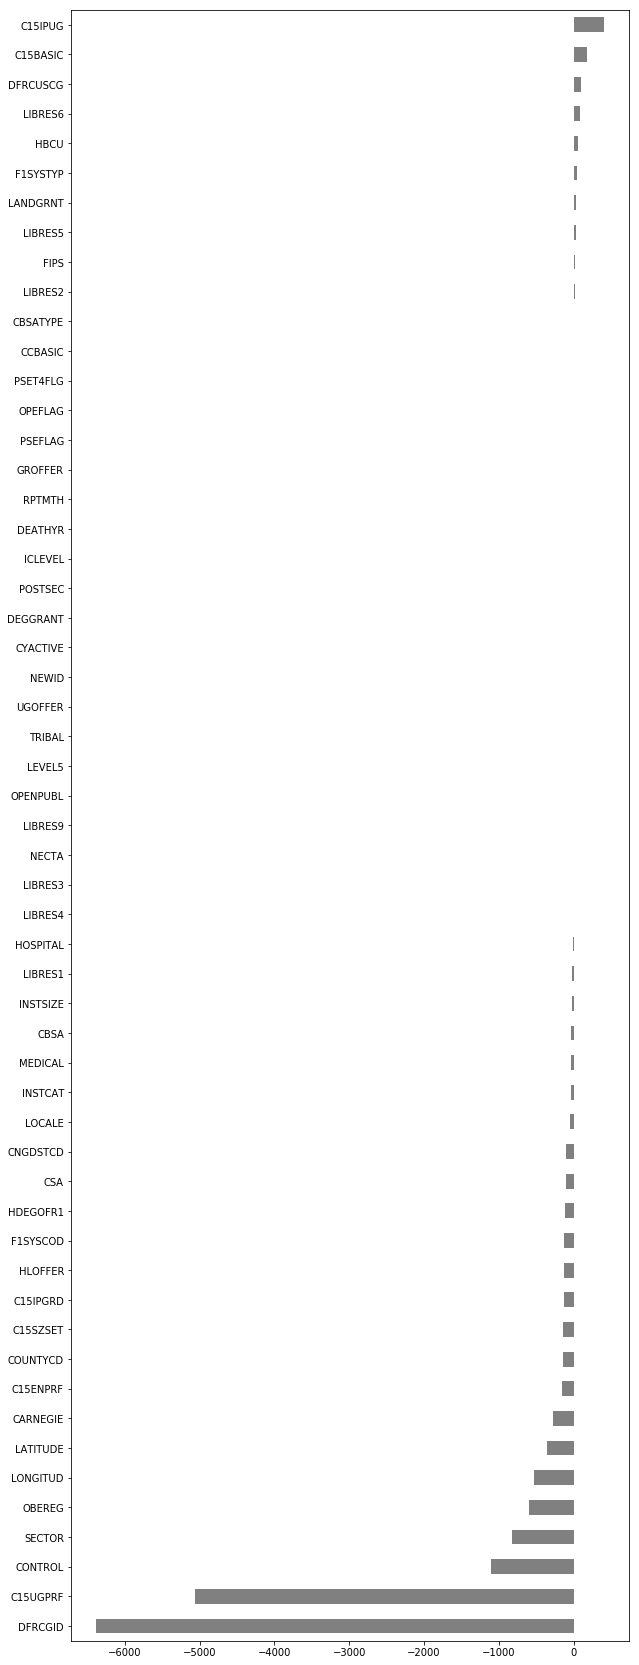

In [54]:
plt.figure(figsize=(10,30))
pd.Series(shap_values[0], X_val.columns).sort_values().plot.barh(color='grey');